In [9]:
import cv2 as cv
import numpy as np
import pandas as pd
import scipy as sc 
import copy
from scipy import ndimage
from google.colab.patches import cv2_imshow
from google.colab.patches import cv2_imshow

In [93]:
img1 = cv.imread('/content/IMG_20221226_105322.jpg')
new_size = (1000, 1000)
img1 = cv.resize(img1, new_size)
img2 = cv.imread('/content/IMG_20221226_105318.jpg')
img2 = cv.resize(img2, new_size)
# img3 = cv.imread('/content/IMG_20221226_095852.jpg')
# img3 = cv.resize(img3, new_size)
# img2 = cv.resize(img2, new_size)
# gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
# gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

In [78]:
type(img1)

numpy.ndarray

In [96]:
def anms(gray_img,dom_corners):  
  params = dict(maxCorners=1000, qualityLevel=0.05, minDistance=7, blockSize=7)
  corners = cv.goodFeaturesToTrack(gray_img,**params)
  corners = corners.reshape(corners.shape[0],2)
  eu_dist = 0
  r = np.full((corners.shape[0],3),np.inf)
  for i in range (corners.shape[0]):
    for j in range(corners.shape[0]):
      xi = int(corners[i,0])          #(i from 0:1000) [i,0]->x-cordinate of ith corner
      yi = int(corners[i,1])          #(i from 0:1000) [0,i]->y-cordinate of ith corner
      xj = int(corners[j,0])          #same for j th pixel
      yj = int(corners[j,1])
      if gray_img[yi,xi]>gray_img[yj,xj]:       #if the intensity of first pixel > second pixel
        eu_dist = (xi-xj)**2+(yi-yj)**2   #calculate the distance between those two pixels
      if eu_dist<r[i,0]:  
        r[i,0] = eu_dist
        r[i,1] = xi
        r[i,2] = yi
  features= r[np.argsort(-r[:,0])]
  best_corners = features[:dom_corners,:]
  return best_corners




In [97]:
def feature_extractor(gray_img,strong_corners,patch_size):
  patch_size = 40
  features = []
  descriptors = np.array(np.zeros((int((patch_size/5)**2),1)))  # (164,1)
  loop_iterator = strong_corners.shape[0]
  pad_img = np.pad(gray_img,(patch_size),'constant',constant_values=0)
  for i in range(loop_iterator):
    patch = pad_img[int(strong_corners[i][2]+(patch_size/2)):int(strong_corners[i][2]+(3*patch_size/2)),int(strong_corners[i][1]+(patch_size/2)):int(strong_corners[i][1]+(3*patch_size/2))]
    blur_patch = cv.GaussianBlur(patch,(5,5),0)
    subsample = blur_patch[0::5,0::5]
    # cv.imwrite(str(i)+'.png',subsample)
    features = subsample.reshape(int((patch_size/5)**2),1)   # (164,1)
    features = features - np.mean(features)
    features = features/np.std(features)
    # cv.imwrite('features'+str(i)+'.png',features)
    descriptors = np.dstack((descriptors,features))
    desc = descriptors[:,:,1:]
  return desc  





In [98]:
def match_pairs(features1,features2,best_corners1,best_corners2):
  des1,unit1,corners1 = features1.shape
  des2,unit2,corners2 = features2.shape
  cmin = 1e+8
  smin = 1e+8
  corners1 = int(min(corners1,corners2))
  corners2 = int(max(corners1,corners2))
  match_pairs = []
  corners1 = int(min(corners1,corners2))
  corners2 = int(max(corners1,corners2))
  for i in range(corners1):
    matches = {}
    for j in range(corners2):
      distance = np.linalg.norm((features1[:,:,i]-features2[:,:,j]))**2
      matches[distance] =[best_corners1[i,:],best_corners2[j,:]]
    sorted_matches = sorted(matches)
    first = sorted_matches[0]
    second = sorted_matches[1]
    if first/second<0.7:
        pairs = matches[first]
        match_pairs.append(pairs)    
  return match_pairs

In [99]:
def showFeatures(img1,img2,matchPairs,new_img_name):
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    ################################################################################################
    r = 15
    thickness = 2
    c = None

    for i in range(len(matchPairs)):
        x1 = int(matchPairs[i][0][1])
        y1 = int(matchPairs[i][0][2])
        x2 = int(matchPairs[i][1][1])+int(img1.shape[1])
        y2 = int(matchPairs[i][1][2])

        cv.line(new_img,(x1,y1),(x2,y2),(0,255,255),2)
        cv.circle(new_img,(x1,y1),3,255,-1)
        cv.circle(new_img,(x2,y2),3,255,-1)

    cv.imwrite(new_img_name,new_img)

In [100]:

#Ransac for outlier rejection
def ransac(pairs, N,t,thresh):
    M = pairs
    H_new = np.zeros((3,3))
    max_inliers = 0
#     N = int(100*np.log(1-t)/np.log(1-(1-0.1)**4))
    # N = 1000
    for j in range(N):

        index = []
        pts = [np.random.randint(0,len(M)) for i in range(4)]
        p1 = np.array([[M[pts[0]][0][1:3]],[M[pts[1]][0][1:3]],[M[pts[2]][0][1:3]],[M[pts[3]][0][1:3]]],np.float32)
        p2 = np.array([[M[pts[0]][1][1:3]],[M[pts[1]][1][1:3]],[M[pts[2]][1][1:3]],[M[pts[3]][1][1:3]]],np.float32)

#         p1 = pts1[pts]
#         p2 = pts2[pts]
        H = cv.getPerspectiveTransform( p1, p2 )
        inLiers = 0
        for ind in range(len(M)):
            source = np.array(M[ind][0][1:3])
            # print('source',source)
            target = np.array(M[ind][1][1:3])
            # print('target',target)
                                 #np.array([M[ind][1][1],M[ind][1][2]])
            predict = np.matmul(H, np.array([source[0],source[1],1]))
            # print('predict',predict)
            if predict[2] == 0:
                predict[2] = 0.000001
            predict_x = predict[0]/predict[2]
            predict_y = predict[1]/predict[2]
            predict = np.array([predict_x,predict_y])
            predict = np.float32([point for point in predict])
            if (np.linalg.norm(target-predict)) < thresh:
                inLiers += 1

                index.append(ind)
        pts1 = []
        pts2 = []
        if max_inliers < inLiers:
            max_inliers = inLiers
            [pts1.append([M[i][0][1:3]]) for i in index]
            [pts2.append([M[i][1][1:3]]) for i in index]
            # p1 =
            H_new,status = cv.findHomography(np.float32(pts1),np.float32(pts2))
            if inLiers > t*len(M):
                print('success')


                break
    pairs = [M[i] for i in index]
    if len(pairs)<=4:
        print('Number of pairs after RANSAC is low')
    return H_new,pairs

In [101]:
def stitch_img(image, homography,image2_shape):
    '''
    image is the input image to be warped
    homography estimated using Ransac
    '''

    # image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    h, w, z = image.shape

    # Find min and max x, y of new image
    p = np.array([[0, w, w, 0], [0, 0, h, h], [1, 1, 1, 1]])
    p_prime = np.dot(homography, p)

    yrow = p_prime[1] / p_prime[2]
    xrow = p_prime[0] / p_prime[2]
    ymin = min(yrow)
    xmin = min(xrow)
    ymax = max(yrow)
    xmax = max(xrow)

    # Make new matrix that removes offset and multiply by homography
    new_mat = np.array([[1, 0, -1 * xmin], [0, 1, -1 * ymin], [0, 0, 1]])
    homography = np.dot(new_mat, homography)

    # height and width of new image frame
    height = int(round(ymax - ymin))+image2_shape[0]
    width = int(round(xmax - xmin))+ image2_shape[1]
    size = (height,width)
    # Do the warp
    warped = cv.warpPerspective(src=image, M=homography, dsize=size)

    return warped, int(xmin), int(ymin)

In [102]:
def Estimated_Homography(img1,img2):
        # else:
        # img1 = images[im+1]
        # img2 = images[-1]
    flag = True
    gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    gray1 = np.float32(gray1)

    gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    gray2 = np.float32(gray2)

    """
    Corner Detection
    Save Corner detection output as corners.png
    """
    corners1 = cv.goodFeaturesToTrack(gray1, 100000, 0.001,10)
    # corners1 = cv2.goodFeaturesToTrack(gray1, 10000, 0.0001,10)
    corners1 = np.int0(corners1)


    i1 = copy.deepcopy(img1)
    for corner in corners1:
        x,y = corner.ravel()
        cv.circle(i1,(x,y),3,255,-1)
    cv.imwrite('corners1.png',i1)

    corners2 = cv.goodFeaturesToTrack(gray2, 100000, 0.001,10)
    # corners1 = cv2.goodFeaturesToTrack(gray1, 10000, 0.0001,10)
    corners2 = np.int0(corners2)


    i2 = copy.deepcopy(img2)
    for corner in corners2:
        x,y = corner.ravel()
        cv.circle(i2,(x,y),3,255,-1)
    cv.imwrite('corners2.png',i2)

    """
    Perform ANMS: Adaptive Non-Maximal Suppression
    Save ANMS output as anms.png
    """
    best_corners1 = anms(gray1, 700)
    # anms1 = copy.deepcopy(img1)
    i1 = copy.deepcopy(img1)
    for corner1 in best_corners1:
        _,x1,y1 = corner1.ravel()
        cv.circle(i1,(int(x1),int(y1)),3,255,-1)
    cv.imwrite('anms1.png',i1)
    best_corners2 = anms(gray2, 700)
    # anms = copy.deepcopy(img2)
    i2 = copy.deepcopy(img2)
    for corner2 in best_corners2:
        _,x2,y2 = corner2.ravel()
        cv.circle(i2,(int(x2),int(y2)),3,255,-1)
    cv.imwrite('anms2.png',i2)
    """
    Feature Descriptors
    Save Feature Descriptor ay2output as FD.png
    """
    feat1 = feature_extractor(gray_img=gray1,strong_corners=best_corners1,patch_size=40)
    feat2 = feature_extractor(gray_img=gray2, strong_corners=best_corners2,patch_size=40)
    """
    Feature Matching
    Save Feature Matching output as matching.png
    """
    matchPairs = match_pairs(features1 = feat1,features2 = feat2, best_corners1 = best_corners1,best_corners2=best_corners2)
    print("Number of matches",len(matchPairs))
    if len(matchPairs)<40:
        print('Error')
        flag = False
    showFeatures(img1,img2,matchPairs,new_img_name = 'matching.png')
    """
    Refine: RANSAC, Estimate Homography
    """
    Hmg,pairs = ransac(matchPairs,N=3000,t=0.9 ,thresh=30.0)
    # showFeatures(img1,img2,matchPairs,new_img_name = 'matching.png')
    showFeatures(img1,img2,pairs,new_img_name = 'ransac.png')

    # Hmg = cv2.findHomography(matchPairs[],)
    return Hmg,flag

In [103]:
def Blend(images):
    img1 = images[0]
    for im in images[1:]:
      
        H,flag = Estimated_Homography(img1,im)
        if flag == False:
            print('Number of matches is less than required')
            break
        
        imgholder, origin_offset_x,origin_offset_y = stitch_img(img1,H,im.shape)
        oX = abs(origin_offset_x)
        oY = abs(origin_offset_y)
        for y in range(oY,im.shape[0]+oY):
            for x in range(oX,im.shape[1]+oX):

                img2_y = y - oY
                img2_x = x - oX
                imgholder[y,x,:] = im[img2_y,img2_x,:]

        img1 = imgholder
    
    
    resize_pano = cv.GaussianBlur(img1,(5,5),1.2)
    cv.imwrite('blur_pano.png',resize_pano)
    return resize_pano

In [106]:
images = [img2,img1]

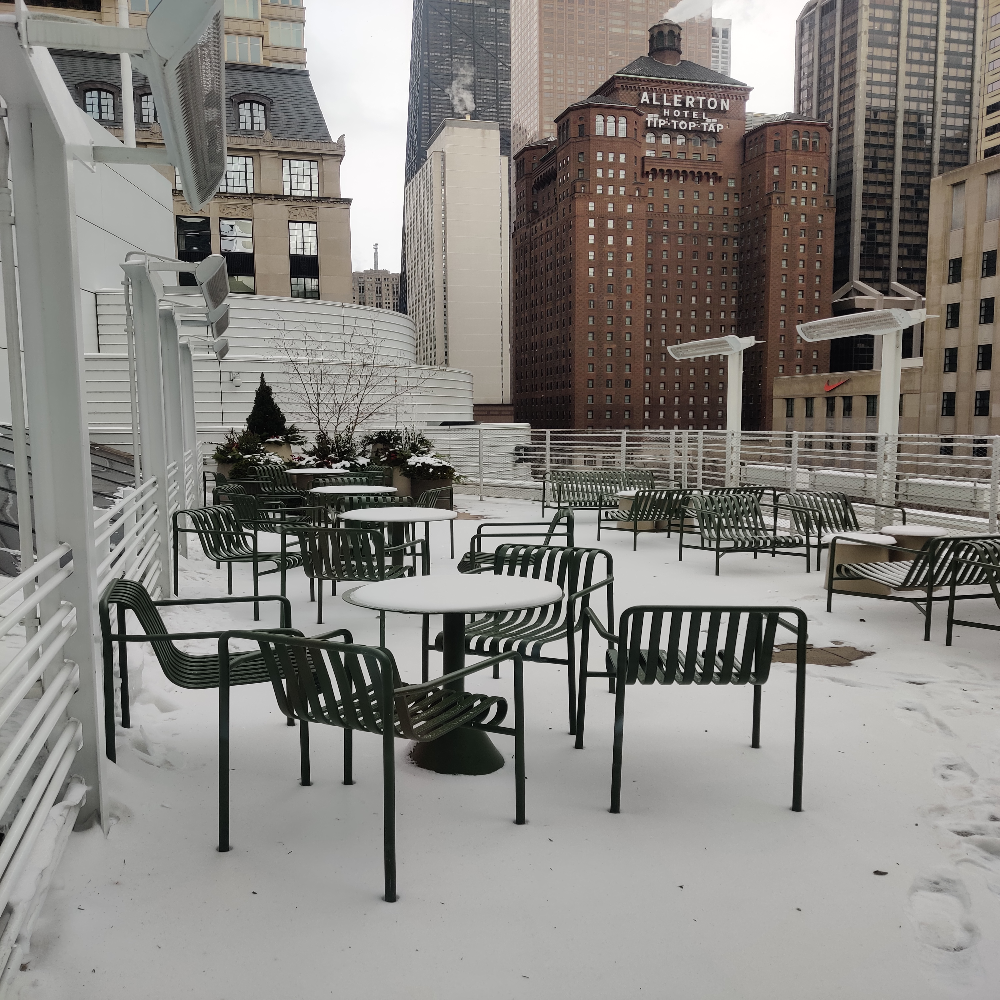

In [95]:
cv2_imshow(img2)

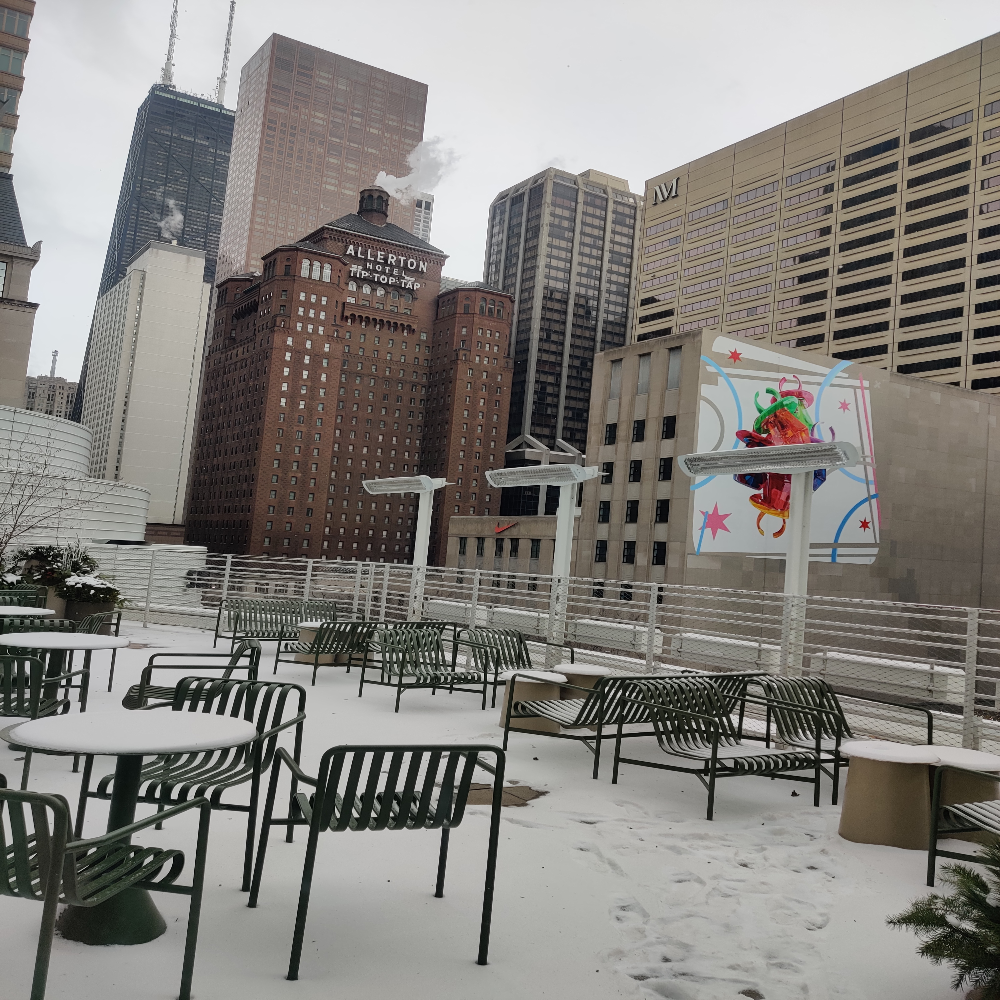

In [94]:
cv2_imshow(img1)

In [107]:
mypano = Blend(images)

Number of matches 142


In [110]:
panorama = cv.imread('/content/blur_pano.png')

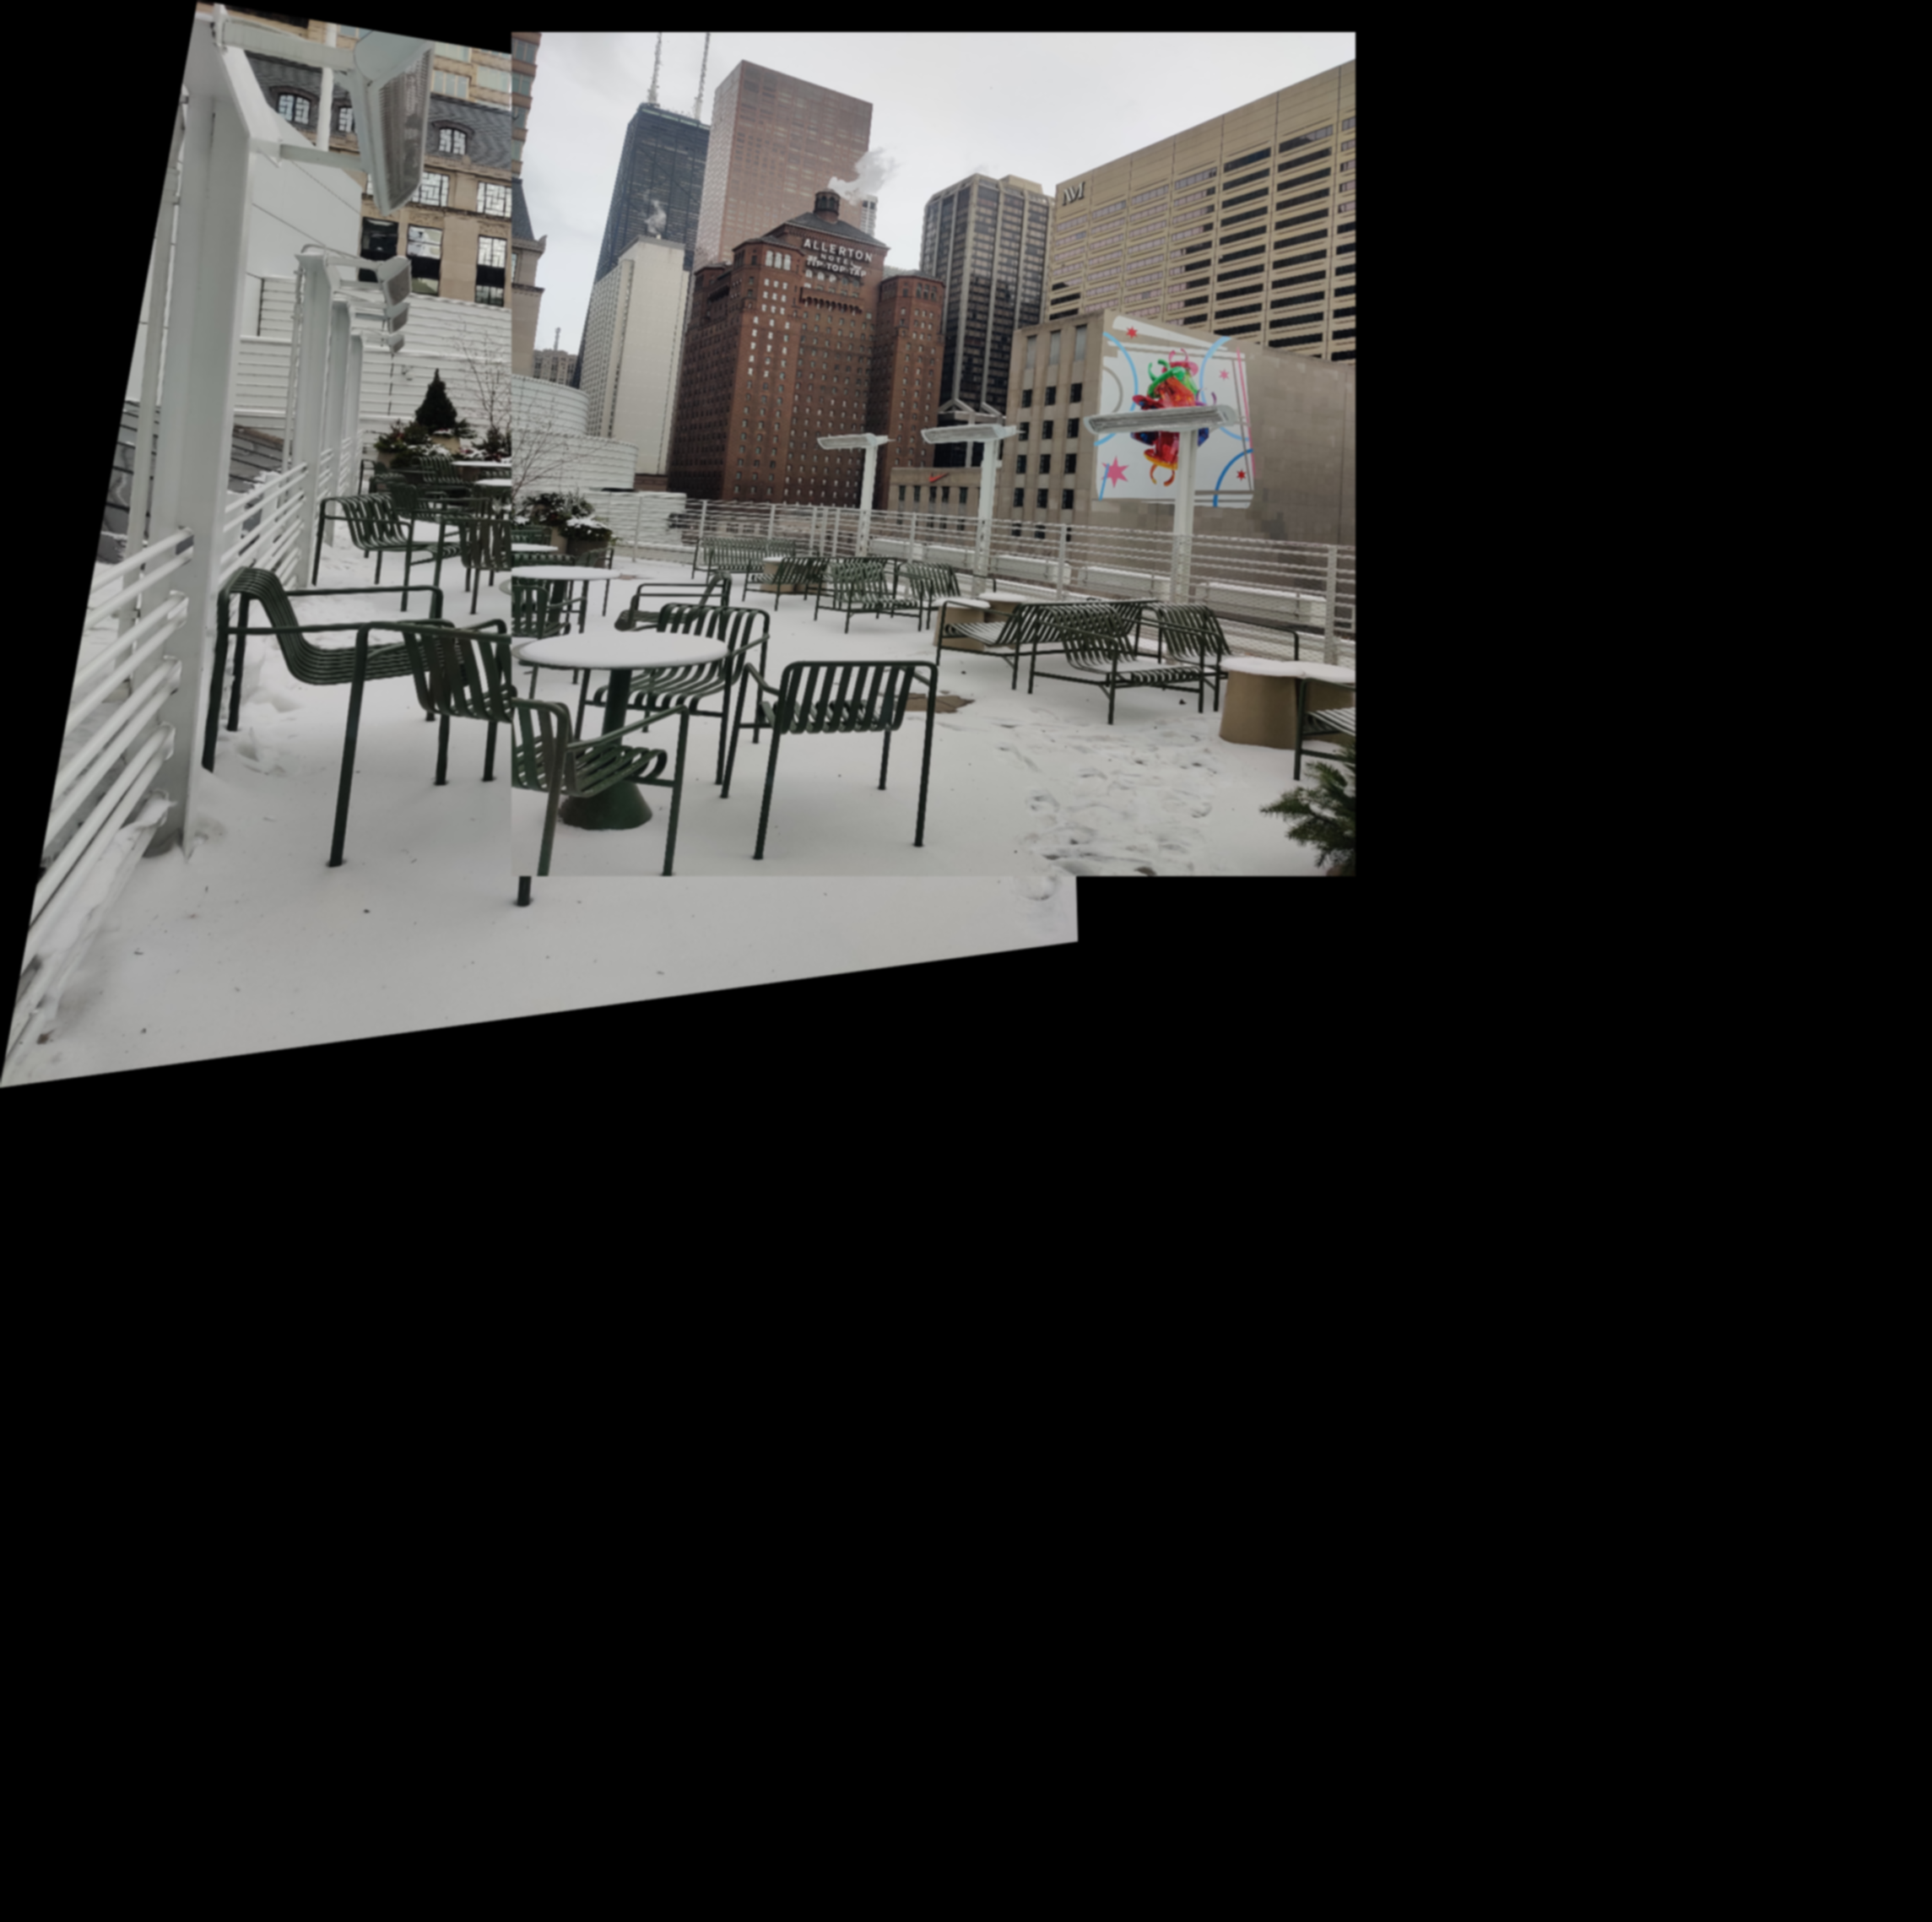

In [111]:
cv2_imshow(panorama)